# Structure-Function Analysis
Written by J. Alexander Bae (jabae@princeton.edu)
- Related to Figure 6.

In [6]:
import numpy as np
import pandas as pd
import pickle

import datajoint as dj

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.sparse import csgraph
from meshparty import skeleton_io
from scipy.sparse.csgraph import shortest_path

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, percentileofscore

from lib.utils import *

%matplotlib inline

/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/python_jsonschema_objects/__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


## Functions

In [7]:
# DataJoint

# Get soma center coordinates ([nm])
def get_soma_loc(database, seg_id):
    
    key = {"segmentation": 185, "segment_id": seg_id}
    
    return (database.Soma() & key).fetch1("loc")/1000


# Get stimulus label
def get_stim_label(database, scan_id):
    
    key = {"scan_id": scan_id}
    
    return (database.Stimulus() & key).fetch1("condition")


# Get functional responses
def get_trace(database, seg_id, scan_id, trace_type="spike"):
    
    trace = (database.EASETrace() & {"segment_id": seg_id, "scan_id": scan_id}).fetch1(trace_type)
    
    return trace

In [8]:
# Analysis

def get_section(conditions, angle):
    
    if np.isnan(angle):
        valid = np.isnan(conditions).astype("int")
    else:
        valid = (conditions==angle).astype("int")
    
    valid_diff = np.diff(valid)
    valid_diff = valid_diff.reshape((1,-1))
    
    st_idx = np.where(valid_diff==1)[1] + 1
    end_idx = np.where(valid_diff==-1)[1]
    
    if st_idx.shape[0] > end_idx.shape[0]:
        end_idx = np.concatenate((end_idx,np.array([len(conditions)])))
    elif st_idx.shape[0] < end_idx.shape[0]:
        st_idx = np.concatenate((np.array([0]),st_idx))
    elif st_idx[0] > end_idx[0]:
        st_idx = np.concatenate((np.array([0]),st_idx))
        end_idx = np.concatenate((end_idx,np.array([len(conditions)])))
    
    section_list = []
    for i in range(st_idx.shape[0]):
        section_list.append((st_idx[i], end_idx[i]+1))
    
    return section_list


def get_peakamp_tdarray(trace, condition):
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    tdarray = np.zeros((30,16))
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)
        
        offset = 0
        for j in range(len(section_list)):
            
            if len(section_list)!=30:
                offset = 30-len(section_list)
                
            s = section_list[j] 
            trace_sect = trace[s[0]:s[1]]
            
            max_idx = np.argmax(trace_sect)
            max_val = trace_sect[max_idx]
            if (max_idx==0):
                tdarray[j+offset,i] = 0      
            elif (max_idx==trace_sect.shape[0]-1):
                trace_post = trace[s[1]:s[1]+15]
                tdarray[j+offset,i] = np.max(trace_post)
            elif trace_sect[0]>0.5*max_val:
                tdarray[j+offset,i] = 0
            else:
                tdarray[j+offset,i] = max_val
    
    return tdarray


def get_active_tdarray(spike, condition, thr=3):
    
    spike = spike*(spike>=thr*np.std(spike))
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    tdarray = np.zeros((30,16))
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)

        for j in range(len(section_list)):

            s = section_list[j]

            spike_section = spike[s[0]:s[1]]
            if np.sum(spike_section) > 0:
                tdarray[j,i] = 1
            else:
                tdarray[j,i] = 0
                
    return tdarray


def compute_intermittency(spike, condition, pref_idx, thr=3):
    
    spike = spike*(spike>=thr*np.std(spike))
    
    valid = ~np.isnan(condition)
    angle_list = np.unique(condition[valid])
    
    trial_arr = np.ones((16,30))*np.nan
    for i in range(angle_list.shape[0]):
        
        angle = angle_list[i]
        section_list = get_section(condition, angle)

        for j in range(len(section_list)):

            s = section_list[j]

            spike_section = spike[s[0]:s[1]]
            if np.sum(spike_section) > 0:
                trial_arr[i,j] = 0
            else:
                trial_arr[i,j] = 1
    
    frac_angle = np.nansum(trial_arr, axis=1)/np.sum(~np.isnan(trial_arr), axis=1) 
    
    return np.mean(frac_angle[pref_idx])

In [41]:
# Plotting

palette = sns.color_palette()

def plot_trace_dir(ax, seg_id, angle, xlab="", ylab=""):
    
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = RawTrace[seg_id]
    spike = Spike[seg_id]
    stimlab = StimulusLabel["scan{}".format(scan_id)]

    section_list = get_section(stimlab, angle)

    for s in section_list:
        n = s[1] - s[0] + 1
        plt.plot(np.arange(0,n*0.0674-0.001,0.0674), trace[s[0]:s[1]+1], linewidth=0.5)

    ax.set_xlim(0,1)
    ax.set_xticks(np.arange(0,1.1,0.5))
    ax.set_xticklabels(np.round(ax.get_xticks(),1), fontsize=15, fontname="Helvetica")
    ax.set_yticklabels(ax.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
    ax.set_xlabel(xlab, fontsize=18, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=18, fontname="Helvetica")
    
    
def plot_linear_fit(xval, yval, xlab, ylab):

    Xval = sm.add_constant(xval)
    re = sm.OLS(yval, Xval).fit()

    xrng = np.max(xval) - np.min(xval)
    xlin = np.linspace(np.min(xval)-0.01*xrng,np.max(xval)+0.01*xrng,100)
    Xlin = sm.add_constant(xlin)
    dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

    plt.figure()
    plt.plot(xval, yval, 'k.', alpha=0.4)
    plt.plot(xlin, dt["mean"], '-', alpha=0.8)
    plt.fill_between(
            xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
            alpha=0.2, color="gray")
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    plt.show()

    r,p = pearsonr(xval, yval)
    print("r = {}, p = {}".format(r,p))
    

def plotax_linear_fit(ax, xval, yval, xlab, ylab):
    
    Xval = sm.add_constant(xval)
    re = sm.OLS(yval, Xval).fit()

    xrng = np.max(xval) - np.min(xval)
    xlin = np.linspace(np.min(xval),np.max(xval),100)
    Xlin = sm.add_constant(xlin)
    dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

    ax.plot(xval, yval, 'k.', alpha=0.2)
    ax.plot(xlin, dt["mean"], '-', color=palette[0], alpha=0.8)
    ax.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
    ax.set_xlabel(xlab, fontsize=18, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=18, fontname="Helvetica")


def plot_interaction_fit(data, fit):
    
    active = data[data.active]
    inactive = data[~data.active]
    
    plt.scatter(active.inconn_density, active.response,
                marker='.', color=palette[3], alpha=0.8)
    plt.scatter(inactive.inconn_density, inactive.response,
                marker='.', color=palette[0], alpha=0.8)
    
    active_preds = fit.get_prediction(active)
    inactive_preds = fit.get_prediction(inactive)
    
    active_confint = active_preds.summary_frame(alpha=0.2)
    inactive_confint = inactive_preds.summary_frame(alpha=0.2)
    
    plot_preds(active, active_confint, palette[3])
    plot_preds(inactive, inactive_confint, palette[0])
    
    
def plot_preds(data, confint, color='k'):
    
    plt.plot(data.inconn_density, confint["mean"], "-", color=color, alpha=0.6)
    order = np.argsort(data.inconn_density)
    plt.fill_between(
        data.inconn_density.values[order],
        confint.obs_ci_lower.values[order],
        confint.obs_ci_upper.values[order],
        alpha=0.2, color="gray")

## Connect to DataJoint database

- You need to be registered to access the database. Please refer to README in the repository for registration.

In [10]:
dj.config["database.host"] = "datajoint.ninai.org"
dj.conn()

pinky = dj.create_virtual_module("seung_pinky", "seung_pinky")

INFO:datajoint.settings:Setting database.host to datajoint.ninai.org


Please enter DataJoint username: jabae
Please enter DataJoint password: ········
Connecting jabae@datajoint.ninai.org:3306


## All pyramidal cells (PyCs)
- 363 pyramidal cells that have soma inside the volume.

In [11]:
pinky.Neuron()

segmentation,segment_id,manual_id
185,648518346349491311,466
185,648518346349492130,499
185,648518346349492197,503
185,648518346349492682,163
185,648518346349493472,549
185,648518346349493487,552
185,648518346349493874,-1
185,648518346349494004,47
185,648518346349494577,462
185,648518346349496405,174


In [12]:
key = {"segmentation": 185}
pyc_list = (pinky.Neuron() & key).fetch("segment_id")
n_pyc = pyc_list.shape[0]

## PyCs with functional data

In [13]:
cell_info_func = pd.read_csv("data/cell_functional_info.csv")

pyc_func_list = np.array(cell_info_func["segment_id"])
scan_list = np.array(cell_info_func["scan"]) + 1
n_func = pyc_func_list.shape[0]

osi_p = np.array(cell_info_func["osi_p"])
dsi_p = np.array(cell_info_func["dsi_p"])

tune_os_idx = osi_p<0.05
tune_ds_idx = dsi_p<0.05
tune_all_idx = tune_os_idx + tune_ds_idx

seg_id_os = pyc_func_list[tune_os_idx]
seg_id_ds = pyc_func_list[tune_ds_idx]
seg_id_tuned = pyc_func_list[tune_all_idx]

cell_info_func

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,1,1.399790,0.0085,0.360205,0.9077
1,648518346349537860,1,1.791797,0.0000,0.379977,0.7241
2,648518346349538440,1,1.369347,0.0025,0.257158,0.9983
3,648518346349538527,1,1.021334,0.0276,0.972555,0.9746
4,648518346349538209,1,1.863632,0.0000,0.100173,0.9763
...,...,...,...,...,...,...
107,648518346349537741,5,1.266736,0.0568,0.528219,0.9732
108,648518346349537901,5,1.163586,0.1148,1.162096,0.1404
109,648518346349538001,5,1.321359,0.0631,1.324058,0.0638
110,648518346349538251,5,1.436740,0.0139,1.399342,0.0287


## PyC - PyC subgraph
- Includes only pyramidal cells that have cell bodies in the volume.
- Connections among these pyramidal cells.

In [11]:
pinky.PycSubgraph()

segmentation,id,pre_root_id,post_root_id,ctr_pt_position,pre_pt_position,post_pt_position,cleft_size,spine_vol
185,1484,648518346349539437,648518346349531254,=BLOB=,=BLOB=,=BLOB=,798,0.133004
185,2254,648518346349537978,648518346349537300,=BLOB=,=BLOB=,=BLOB=,129,0.0163458
185,3785,648518346349533058,648518346349538715,=BLOB=,=BLOB=,=BLOB=,62,0.0209691
185,3863,648518346349539333,648518346349539806,=BLOB=,=BLOB=,=BLOB=,62,0.0180326
185,4062,648518346349523975,648518346349537716,=BLOB=,=BLOB=,=BLOB=,62,0.00880545
185,4075,648518346349538478,648518346349536788,=BLOB=,=BLOB=,=BLOB=,62,0.0599059
185,6065,648518346349533350,648518346349539579,=BLOB=,=BLOB=,=BLOB=,62,0.0134518
185,6119,648518346349538711,648518346349537993,=BLOB=,=BLOB=,=BLOB=,1513,0.314781
185,8311,648518346349538157,648518346349539856,=BLOB=,=BLOB=,=BLOB=,62,0.0223994
185,11704,648518346349537385,648518346349539579,=BLOB=,=BLOB=,=BLOB=,62,0.023261


## Get soma center coordinates

In [15]:
pinky.Soma()

segmentation,segment_id,manual_id,loc
185,648518346349491311,466,=BLOB=
185,648518346349492130,499,=BLOB=
185,648518346349492197,503,=BLOB=
185,648518346349492682,163,=BLOB=
185,648518346349493472,549,=BLOB=
185,648518346349493487,552,=BLOB=
185,648518346349493874,-1,=BLOB=
185,648518346349494004,47,=BLOB=
185,648518346349494577,462,=BLOB=
185,648518346349496405,174,=BLOB=


#### All PyCs

In [14]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(pinky, seg_id)

#### PyCs with functional data

In [15]:
pyc_func_soma_loc = np.zeros((n_func, 3))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_func_soma_loc[i,:] = pyc_soma_loc[idx,:]

## Compute dendrite length
- Unit: [$\mu$m]

#### All PyCs

In [16]:
d_skel = "data/smoothed_skeletons_v185/"

# Calculate dendrite length
dendrite_len = np.zeros((n_pyc,)) # In microns
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    seg_lab = np.load(d_skel+str(seg_id)+"_skeleton_label.npy")
    seg_skel = skeleton_io.read_skeleton_h5(d_skel+str(seg_id)+"_skeleton.h5")
    
    g = seg_skel.csgraph
    dend_idx = np.where((seg_lab==2)+(seg_lab==3)+(seg_lab==4))[0]
    g = g[dend_idx][:,dend_idx]
    
    dendrite_len[i] = np.sum(g)/1000

#### PyCs with functional data

In [17]:
dendrite_len_func = np.zeros(n_func)
for i in range(n_func):
    seg_id = pyc_func_list[i]
    dendrite_len_func[i] = dendrite_len[pyc_list==seg_id] 

## Compute in-connection density

In [25]:
pre_id_all = pinky.PycSubgraph().fetch("pre_root_id")
post_id_all = pinky.PycSubgraph().fetch("post_root_id")

real_synapse = np.zeros((pre_id_all.shape[0],2), dtype=np.uint64)
real_synapse[:,0] = pre_id_all
real_synapse[:,1] = post_id_all
real_connection = np.unique(real_synapse, axis=0)

/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/datajoint/connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


In [26]:
# In/out degree
# Computing only for cells with functional data
insyn_deg = np.zeros((n_func)) # In-synapse degree
inconn_deg = np.zeros((n_func)) # In-connection degree
outsyn_deg = np.zeros((n_func)) # Out-synapse degree
outconn_deg = np.zeros((n_func)) # Out-connection degree

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    
    outsyn_deg[i] = np.sum(real_synapse[:,0]==seg_id)
    insyn_deg[i] = np.sum(real_synapse[:,1]==seg_id)
    
    outconn_deg[i] = np.sum(real_connection[:,0]==seg_id)
    inconn_deg[i] = np.sum(real_connection[:,1]==seg_id)

In [27]:
# In-connection density
inconn_density = inconn_deg/dendrite_len_func

## Compute total in-synapse density

In [19]:
synapse_all_pyc_df = pd.DataFrame(data=pinky.PycSynapse().fetch())
synapse_all_pyc_df

,segmentation,id,pre_root_id,post_root_id,ctr_pt_position,pre_pt_position,post_pt_position,cleft_size
0,185,1,648518346344505885,648518346349537984,"[54623, 41105, 1898]","[54560, 41084, 1899]","[54606, 41142, 1899]",127
1,185,2,648518346342561389,648518346349537380,"[111617, 68901, 172]","[111618, 68848, 170]","[111536, 68888, 170]",153
2,185,5,648518346341408101,648518346349507351,"[99676, 73497, 1440]","[99656, 73460, 1441]","[99584, 73470, 1439]",112
3,185,6,648518346349533058,648518346342805464,"[56024, 42669, 1562]","[56020, 42658, 1566]","[55970, 42702, 1566]",714
4,185,22,648518346347971764,648518346349538718,"[76047, 42915, 709]","[76020, 42954, 713]","[75996, 42872, 712]",608
...,...,...,...,...,...,...,...,...
902304,185,3556630,648518346346314910,648518346349538378,"[78320, 55200, 2101]","[78330, 55234, 2100]","[78314, 55176, 2101]",61
902305,185,3556632,648518346342798934,648518346349539856,"[70750, 56788, 902]","[70760, 56782, 905]","[70702, 56780, 904]",224
902306,185,3556638,648518346342799568,648518346349539781,"[59582, 42104, 747]","[59556, 42132, 747]","[59610, 42086, 747]",61
902307,185,3556639,648518346345304931,648518346349538387,"[59570, 42510, 777]","[59506, 42486, 778]","[59606, 42526, 778]",61


In [21]:
post_id_all = np.array(synapse_all_pyc_df["post_root_id"])
post_idx = np.where(np.isin(post_id_all, pyc_list))[0]

synapse_post_pyc_df = synapse_all_pyc_df.iloc[post_idx]

post_centroids = np.zeros((post_idx.shape[0],3))
for i in range(post_idx.shape[0]):
    post_centroids[i,:] = synapse_post_pyc_df.iloc[i]["ctr_pt_position"]

post_id_list = np.array(synapse_post_pyc_df["post_root_id"])
post_soma_loc = np.zeros(post_centroids.shape)
for i in range(post_id_list.shape[0]):  
    post_soma_loc[i,:] = pyc_soma_loc[pyc_list==post_id_list[i],:]
    
res = np.array([0.004, 0.004, 0.04])
post_centroids = post_centroids*res

# Filter out synapses within 15 um from the soma to remove perisomatic synapses.
d_post = distance(post_centroids, post_soma_loc)
valid = (d_post>15)

# All incoming synapses to pyramidal cells without perisomatic synapses.
synapse_post_pyc_df = synapse_post_pyc_df.iloc[valid]
synapse_post_pyc_df

,segmentation,id,pre_root_id,post_root_id,ctr_pt_position,pre_pt_position,post_pt_position,cleft_size
0,185,1,648518346344505885,648518346349537984,"[54623, 41105, 1898]","[54560, 41084, 1899]","[54606, 41142, 1899]",127
1,185,2,648518346342561389,648518346349537380,"[111617, 68901, 172]","[111618, 68848, 170]","[111536, 68888, 170]",153
2,185,5,648518346341408101,648518346349507351,"[99676, 73497, 1440]","[99656, 73460, 1441]","[99584, 73470, 1439]",112
4,185,22,648518346347971764,648518346349538718,"[76047, 42915, 709]","[76020, 42954, 713]","[75996, 42872, 712]",608
5,185,25,648518346346953536,648518346349539863,"[69361, 52441, 436]","[69344, 52400, 437]","[69326, 52460, 436]",226
...,...,...,...,...,...,...,...,...
902304,185,3556630,648518346346314910,648518346349538378,"[78320, 55200, 2101]","[78330, 55234, 2100]","[78314, 55176, 2101]",61
902305,185,3556632,648518346342798934,648518346349539856,"[70750, 56788, 902]","[70760, 56782, 905]","[70702, 56780, 904]",224
902306,185,3556638,648518346342799568,648518346349539781,"[59582, 42104, 747]","[59556, 42132, 747]","[59610, 42086, 747]",61
902307,185,3556639,648518346345304931,648518346349538387,"[59570, 42510, 777]","[59506, 42486, 778]","[59606, 42526, 778]",61


In [22]:
### Degree of cells with calcium signals
pre_id_all = synapse_post_pyc_df["pre_root_id"]
post_id_all = synapse_post_pyc_df["post_root_id"]
real_synapse_all = np.zeros((pre_id_all.shape[0],2), dtype=np.uint64)
real_synapse_all[:,0] = pre_id_all
real_synapse_all[:,1] = post_id_all

total_insyn_density = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    total_insyn_density[i] = np.sum(real_synapse_all[:,1]==seg_id)/dendrite_len_func[i]

## Response strength

In [23]:
mean_response = np.zeros(n_func)
mean_active_response = np.zeros(n_func)
response_arrays = dict()
active_arrays = dict()

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace_raw = get_trace(pinky, seg_id, scan_id, "trace_raw")
    trace = get_trace(pinky, seg_id, scan_id, "trace")
    spike = get_trace(pinky, seg_id, scan_id, "spike")
    stimlab = get_stim_label(pinky, scan_id)
    
    response_array = get_peakamp_tdarray(trace_raw, stimlab)
    denoised_response_array = get_peakamp_tdarray(trace, stimlab)
    active_array = get_active_tdarray(spike, stimlab)
    
    u, s, vh = np.linalg.svd(denoised_response_array, full_matrices=False)
    resp_dir = np.abs(vh[0,:])
    resp_t = np.abs(u[:,0])
    pref_idx = np.where(resp_dir>np.mean(resp_dir))[0]
    
    response_active_array = response_array*active_array
    response_active_array[response_active_array==0] = np.nan
    
    mean_response[i] = np.nanmean(response_array[:,pref_idx])
    mean_active_response[i] = np.nanmean(response_active_array[:,pref_idx])
    
    # storing information for conditional analysis
    response_arrays[seg_id] = response_array[:,pref_idx]
    active_arrays[seg_id] = active_array[:,pref_idx]

/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/datajoint/connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


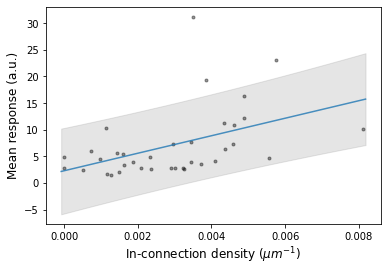

r = 0.4569638381195226, p = 0.0050829630961622095


In [28]:
plot_linear_fit(inconn_density[tune_all_idx], mean_response[tune_all_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Mean response (a.u.)")

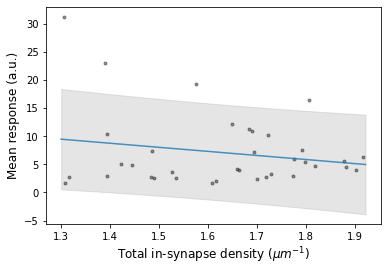

r = -0.20018158442905973, p = 0.24176122819757598


In [29]:
plot_linear_fit(total_insyn_density[tune_all_idx], mean_response[tune_all_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Mean response (a.u.)")

## Intermittency

In [31]:
intermittency = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = get_trace(pinky, seg_id, scan_id, "trace")
    spike = get_trace(pinky, seg_id, scan_id, "spike")
    stimlab = get_stim_label(pinky, scan_id)
    
    response_array = get_peakamp_tdarray(trace, stimlab)
    u, s, vh = np.linalg.svd(response_array, full_matrices=False)
    resp_dir = np.abs(vh[0,:])
    resp_t = np.abs(u[:,0])
    
    pref_idx = np.where(resp_dir>np.mean(resp_dir))[0]
    intermittency[i] = compute_intermittency(spike, stimlab, pref_idx, thr=3)

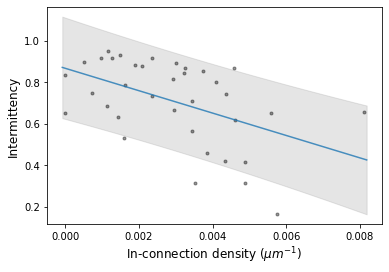

r = -0.485167169914788, p = 0.002707313286705971


In [32]:
plot_linear_fit(inconn_density[tune_all_idx], intermittency[tune_all_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Intermittency")

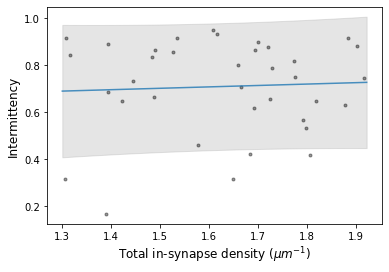

r = 0.053436859246335885, p = 0.7569206031598172


In [34]:
plot_linear_fit(total_insyn_density[tune_all_idx], intermittency[tune_all_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Intermittency")

## Mean active/inactive response

In [ ]:
tuned_segids = pyc_func_list[tune_all_idx]
intermittencies = intermittency[tune_all_idx]
densities = inconn_density[tune_all_idx]
segid_col = list()
active_col = list()
response_col = list()
intermit_col = list()
inconn_col = list()

for (segid, interm, icdensity) in zip(
    tuned_segids, intermittencies, densities):
    
    active_col.append(active_arrays[segid].ravel())
    response_col.append(response_arrays[segid].ravel())
    length = len(active_arrays[segid].ravel())
    segid_col.append(np.repeat(segid, length))
    intermit_col.append(np.repeat(interm, length))
    inconn_col.append(np.repeat(icdensity, length))
    
cond_df = pd.DataFrame.from_dict({
    "segid": np.concatenate(segid_col),
    "active": np.concatenate(active_col).astype("bool"),
    "response": np.concatenate(response_col),
    "intermittency": np.concatenate(intermit_col),
    "inconn_density": np.concatenate(inconn_col)
})

In [48]:
data = cond_df.groupby(["active", "segid"]).mean().reset_index()
fit = smf.ols(formula="response ~ active * inconn_density", data=data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     39.20
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           7.94e-15
Time:                        17:44:41   Log-Likelihood:                -231.43
No. Observations:                  72   AIC:                             470.9
Df Residuals:                      68   BIC:                             480.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.7374      1.985      0.875      0.384      -2.224       5.698
active[T.True]                    7.8426      2.807      2.794      0.007       2.241      13.444
inconn_density                  114.2475    580.902      0.197      0.845   -1044.925    1273.420
active[T.True]:inconn_density  2318.1834    821.520      2.822      0.006     678.866    3957.501
==============================================================================
Omnibus:                       47.212   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.250
Skew:                           1.970   Prob(JB):                     9.79e-41
Kurtosis:                       9.775   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

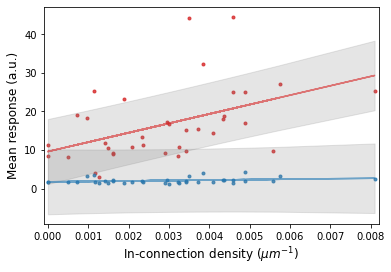

In [49]:
plt.figure()
plot_interaction_fit(data, fit)
plt.xlim(data.inconn_density.min() - 1e-4, data.inconn_density.max() + 1e-4)
plt.xlabel("In-connection density ($\mu m^{-1}$)", fontsize=12)
plt.ylabel("Mean response (a.u.)", fontsize=12)
plt.show()

## Spatial location restricted permutation test

In [35]:
xloc = pyc_func_soma_loc[tune_all_idx,0]
yloc = pyc_func_soma_loc[tune_all_idx,1]
zloc = pyc_func_soma_loc[tune_all_idx,2]

xbins = np.linspace(np.min(xloc), np.max(xloc)*1.001, 3); nx = xbins.shape[0]-1
ybins = np.linspace(np.min(yloc), np.max(yloc)*1.001, 5); ny = ybins.shape[0]-1
zbins = np.linspace(np.min(zloc), np.max(zloc)*1.001, 3); nz = zbins.shape[0]-1

val_density = inconn_density[tune_all_idx]
indices = np.arange(val_density.shape[0])

idx_list = []
density_list = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            
            valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
                    *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
                    *(zloc>=zbins[k])*(zloc<zbins[k+1])
            
            density_bin = val_density[valid]
            
            idx_list.append(indices[valid])
            density_list.append(density_bin)

### Mean response

In [36]:
xval = mean_response[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_resp = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_resp[t] = r

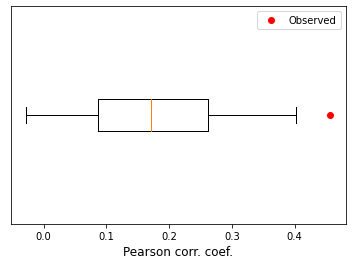

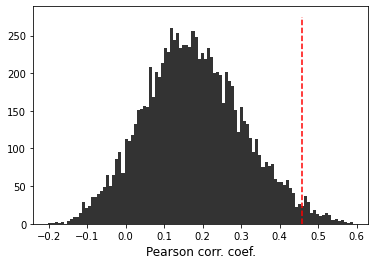

p = 0.02069999999999994


In [37]:
r_true_resp, p_true_resp = pearsonr(inconn_density[tune_all_idx], mean_response[tune_all_idx])

plt.figure()
plt.boxplot(rand_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_resp, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_resp, r_true_resp)/100))

### Intermittency

In [38]:
xval = intermittency[tune_all_idx]
yval = inconn_density[tune_all_idx]

T = 10000
rand_int = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_int[t] = r

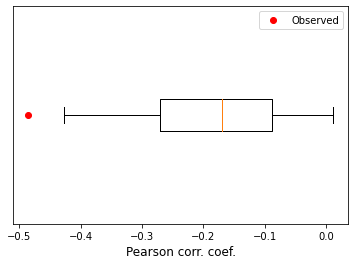

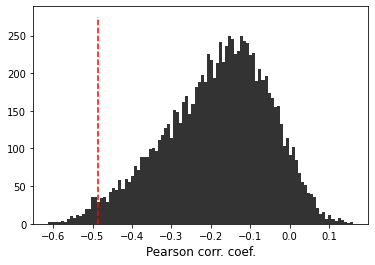

p = 0.020099999999999996


In [39]:
r_true_int, p_true_int = pearsonr(inconn_density[tune_all_idx], intermittency[tune_all_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(percentileofscore(rand_int, r_true_int)/100))

## Figure 6 plot

/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


NameError: name 'data' is not defined

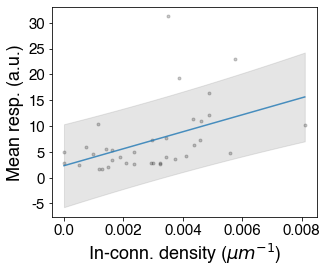

In [42]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)
gs = fig.add_gridspec(8,12)

# In-connection density vs. mean response
ax1 = fig.add_subplot(gs[:4,:4])
plotax_linear_fit(ax1, inconn_density[tune_all_idx], mean_response[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Mean resp. (a.u.)")
ax1.set_xticklabels(np.round(ax1.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax1.set_yticklabels(ax1.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
ax1.set_xlim(data.inconn_density.min() - 1e-4, data.inconn_density.max() + 1e-4)

# Total in-synapse density vs. mean response
ax2 = fig.add_subplot(gs[:4,4:8])
plotax_linear_fit(ax2, total_insyn_dens[tune_all_idx], mean_response[tune_all_idx], xlab="Total in-syn. density ($\mu m^{-1}$)", ylab="Mean resp. (a.u.)")
ax2.set_xticklabels(np.round(ax2.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax2.set_yticklabels(ax2.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
ax2.set_xlim(1.3 - 1e-4, total_insyn_dens[tune_all_idx].max() + 1e-4)

# In-connection density vs. active mean response
ax3 = fig.add_subplot(gs[:4,8:])
plot_interaction_fit(data, fit)
ax3.set_xlim(data.inconn_density.min() - 1e-4, data.inconn_density.max() + 1e-4)
ax3.set_xticklabels(np.round(ax3.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax3.set_yticklabels(ax3.get_yticks().astype("int"), fontsize=15, fontname="Helvetica")
ax3.set_xlabel("In-conn. density ($\mu m^{-1}$)", fontsize=18, fontname="Helvetica")
ax3.set_ylabel("Mean resp. (a.u.)", fontsize=18, fontname="Helvetica")

# In-connection density vs. intermittency
ax4 = fig.add_subplot(gs[4:,:4])
plotax_linear_fit(ax4, inconn_density[tune_all_idx], intermittency[tune_all_idx], xlab="In-conn. density ($\mu m^{-1}$)", ylab="Intermittency")
ax4.set_xticklabels(np.round(ax4.get_xticks(),3), fontsize=15, fontname="Helvetica")
ax4.set_yticklabels(np.round(ax4.get_yticks(),1), fontsize=15, fontname="Helvetica")
ax4.set_xlim(data.inconn_density.min() - 1e-4, data.inconn_density.max() + 1e-4)

# Total in-synapse density vs. intermittency
ax5 = fig.add_subplot(gs[4:,4:8])
plotax_linear_fit(ax5, total_insyn_dens[tune_all_idx], intermittency[tune_all_idx], xlab="Total in-syn. density ($\mu m^{-1}$)", ylab="Intermittency")
ax5.set_xticklabels(np.round(ax5.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax5.set_yticklabels(np.round(ax5.get_yticks(),1), fontsize=15, fontname="Helvetica")
ax5.set_xlim(1.3 - 1e-4, total_insyn_dens[tune_all_idx].max() + 1e-4)

ax6 = fig.add_subplot(gs[4:6,8:])
ax6.hist(rand_resp, bins=100, color="k", alpha=0.8)
ax6.vlines(r_true_resp, ax6.get_ylim()[0], ax6.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax6.set_xticklabels(np.round(ax6.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax6.set_yticklabels(np.round((ax6.get_yticks()/10000),3), fontsize=15, fontname="Helvetica")
ax6.set_title("Mean response", fontsize=18, fontname="Helvetica")

ax7 = fig.add_subplot(gs[6:,8:])
ax7.hist(rand_int, bins=100, color="k", alpha=0.8)
ax7.vlines(r_true_int, ax7.get_ylim()[0], ax7.get_ylim()[1], color="r", linestyle="--", alpha=0.8)
ax7.set_xticklabels(np.round(ax7.get_xticks(),2), fontsize=15, fontname="Helvetica")
ax7.set_yticklabels(np.round((ax7.get_yticks()/10000),3), fontsize=15, fontname="Helvetica")
ax7.set_xlabel("Correlation coef.", fontsize=18, fontname="Helvetica")
ax7.set_title("Intermittency", fontsize=18, fontname="Helvetica")

# plt.savefig("fig6_plots.svg")
plt.show()